<img src='https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/tools/frameworks/-/raw/main/img/OSI-SAF_banner.png' align='right' width='100%'/>

<a href="../Index.ipynb" target="_blank"><< Index</a>
<br>
<a href="./1_2_OSI_SAF_sea_ice_file_structure.ipynb" target="_blank"><< Exploring OSI SAF sea ice file structure</a>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="./1_3b_OSI_SAF_sea_ice_mapping_Ice_Edge.ipynb" target="_blank">Mapping OSI SAF sea ice edge >></a>

<font color="#138D75">**EUMETSAT OSI SAF Training Service**</font> <br>
**Copyright:** 2026 EUMETSAT <br>
**License:** MIT

<html>
  <div style="width:100%">
    <div style="float:left"><a href="https://mybinder.org/v2/git/https%3A%2F%2Fgitlab.eumetsat.int%2Feumetlab%2Foceans%2Focean-training%2Fsensors%2Flearn-osi-saf-sea-ice/HEAD?labpath=1_OSI_SAF_sea_ice_introductory%2F1_3a_OSI_SAF_sea_ice_mapping_ice_concentration.ipynb"><img src="https://mybinder.org/badge_logo.svg" alt="Open in Binder"></a></div>
    <div style="float:left"><p>&emsp;</p></div>
  </div>
</html>

<div class="alert alert-block alert-success">
<h3>Learn OSI SAF sea ice parameters : Introductory</h3></div>

<div class="alert alert-block alert-warning">
    
<b>PREREQUISITES </b>
    
The following modules are prerequisites for this notebook, and will retrieve the data required here.
  - **<a href="./1_1_OSI_SAF_sea_ice_FTP_data_access.ipynb" target="_blank">1_1a_OSI_SAF_sea_ice_FTP_data_access.ipynb</a>**

</div>
<hr>

# 1.3a Mapping OSI SAF sea ice concentration 
### Data used 

| Dataset | EUMETSAT collection ID | OSI SAF website description | OSI SAF identifier |
|:-----------------:|:-----------------:|:-----------------:|:-----------------:|
| Global Sea Ice Concentration (AMSR-2) | EO:EUM:DAT:GCOM:OSI-408 | <a href="https://osi-saf.eumetsat.int/products/osi-408-a" target="_blank">Description</a> | OSI-408-a | 
| Level 2 PMW sea ice concentration | - | <a href="https://osi-saf.eumetsat.int/products/osi-410-a" target="_blank">Description</a> | OSI-410-a | 
| Global Sea Ice Concentration climate data record (SMMR/SSMI/SSMIS), release 3 | EO:EUM:DAT:0826 | <a href="https://osi-saf.eumetsat.int/products/osi-450-a" target="_blank">Description</a> | OSI-450-a 
| Global Sea Ice Concentration interim climate data record, release 3 | EO:EUM:DAT:0645 | <a href="https://osi-saf.eumetsat.int/products/osi-430-a" target="_blank">Description</a> | OSI-430-a |
| Global Sea Ice Concentration climate data record (AMSR), release 3 | EO:EUM:DAT:0797 | <a href="https://osi-saf.eumetsat.int/products/osi-458" target="_blank">Description</a> | OSI-458 |
| Global Sea Ice Concentration interim climate data record (AMSR2), release 3 | - | <a href="https://osi-saf.eumetsat.int/products/osi-438" target="_blank">Description</a> | OSI-438 |

### Learning outcomes

At the end of this notebook you will know;
* How to open Sea Ice Concentration netcdf
* Map Sea Ice Concentration using cartopy 

<div class="alert alert-info" role="alert">

## <a id='TOC-TOP'></a>Contents

</div>
    
 1. [Mapping near real time data - Global Sea Ice Concentration (AMSR2)](#section1)
 1. [Mapping near real time data - Level 2 PMW sea ice concentration](#section2)
 1. [Mapping climate data - Global Sea Ice Concentration climate data record (SMMR/SSMI/SSMIS), release 3](#section3)
 1. [Mapping climate data - Global Sea Ice Concentration climate data record (AMSR), release 3](#section4)
 1. [Mapping climate data - Global Sea Ice Concentration interim climate data record (AMSR), release 3](#section5)
 


<hr>

We begin by importing all of the libraries that we need to run this notebook. If you have built your python using the environment file provided in this repository, then you should have everything you need. For more information on building environment, please see the repository **<a href="../README.md" target="_blank">README</a>**.

In [1]:
# library imports 
import os                          # a library that allows us access to basic operating system commands
import xarray as xr                # a library that supports the use of multi-dimensional arrays in Python
import matplotlib as mpl           # a library for visualization
import matplotlib.pyplot as plt    # a library that supports plotting
import matplotlib.cm as mpl_cm     # a part of the plotting library that provides colour maps
import cartopy.crs as ccrs         # a mapping library that supports reprojection
import cartopy.feature as cfeature # a part of the mapping library that provides features such as coastlines
import cmocean                     # colormaps for ocean products
import cmcrameri                   # scientific colormaps for data visualisation
import numpy as np                 # a library that supports array manipulation
import urllib                      # a library that helps us read in remote resources from URLs
from PIL import Image              # a library that helps us plot images
import warnings                    # a library that controls python warnings
warnings.filterwarnings('ignore')

##
<div class="alert alert-warning" role="alert">

## <a id='section0'></a>0. Supporting functions
[Back to top](#TOC-TOP)

</div>

Before we begin, we will define shorts functions.

The function name `mapping_ice_conc` create a plot figure of sea ice concentration product available in the directory **dir** with a specific output projection and a specific region of the globe if given.

In [87]:
def mapping_ice_conc(directory, data_projection, output_projection, cmap, ax=None, ice_shelves=None, title="", region=None):
    """
    Function to map Sea Ice Concentration. 

    Args:
        dir (string)        : the directory where files are
        data_projection     : the input projection of data
        output_projection   : the output projection to plot map
        cmap                : color palette
        ax                  : axes of the plot
        ice_shelves         : ice shelves for southern hemisphere
        region (list)       : the region to zoom in. If not region is given, plot a global map
        title (string)      : title of the plot
    Returns:
        im                  : the plotting figure
    """
    
    # define plot carateristics
    if ax==None: ax = plt.axes([0.05,0.05,0.75,0.85], projection=output_projection)
    if region: ax.set_extent(region, crs=data_projection)
    ax.add_feature(cfeature.OCEAN, zorder=0, facecolor=cmap(0)) # Default color of ocean. We set it as the value "open ocean" of the colourmap (to be select below).
    ax.add_feature(cfeature.LAND, zorder=0, facecolor='grey')  # Default color of land.
    ax.gridlines(draw_labels=True)   # Add grid line with latitude and logitude label 
    #ax.coastlines()    # Add coastline
    if ice_shelves: ax.add_feature(ice_shelves, )
    
    # Add title
    plt.title(title, fontsize=18)
    
    # open and plot data
    for filename in os.listdir(directory):
        if filename.endswith(".nc"):
            nc = xr.open_dataset(os.path.join(directory, filename))
            try:
                lon = nc.variables['lon'][:] 
                lat = nc.variables['lat'][:]
                ice_conc = nc.variables['ice_conc'][:]
                xc = nc.variables['xc'][:] 
                yc = nc.variables['yc'][:]
            except:
                try:
                    ice_conc = nc.variables['ice_conc_osi'][:]
                except:
                    pass
                pass

            nc.close()
            
            # plotting sea ice conc
            if data_projection==ccrs.PlateCarree(): 
                im = ax.pcolormesh(lon,lat, ice_conc[0,:,:], transform=data_projection, cmap=cmap)
            else : 
                # Sea Ice Concentration data is provided in x y coordinates, bounds need to be defined for cartopy
                bounds=(xc.min()*1000,xc.max()*1000,yc.min()*1000,yc.max()*1000)
                im = ax.imshow(ice_conc[0,:,:], transform=data_projection, extent=bounds, origin='upper', cmap=cmap)

    return im

The function name `add_colorbar` create a colorbar of the image im.

In [3]:
def add_colorbar(im, fig, orientation, cmap, discrete=False, extend='neither'):
    """
    Function to add a colormap. 

    Args:
        im                         : image
        fig                        : figure
        orientation (string)       : the orientation of colorbar (horizontal or vertical)
        cmap                       : color palette
        dicrete (bool)             : add discrete color
        extend                     : extension type of the colorbar (neither, max, min or both) 
    """
    
    if orientation == 'horizontal':
        axc = fig.add_axes((0.05,0.1,0.75,0.02))
        ax = fig.add_axes([0.38,0.12,0.1,0.05], anchor='S', zorder=-1 )
    else :
        axc = fig.add_axes((0.8,0.05,0.02,0.8))
        ax = fig.add_axes([0.7,.85,0.2,0.05], anchor='S', zorder=-1 )

    if discrete:
        bounds = range(int(im.get_clim()[0]),int(im.get_clim()[1]))
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
        cb = plt.colorbar(im, orientation=orientation, cax=axc, extend=extend, norm=norm, spacing='proportional', ticks=bounds, boundaries=bounds)
    else:
        cb = plt.colorbar(im, orientation=orientation, cax=axc, extend=extend)

    url = "https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/tools/frameworks/-/raw/main/img/OSISAF_Name_Colour.png"
    logo = np.array(Image.open(urllib.request.urlopen(url)))
    
    ax.imshow(logo)
    ax.axis('off')
    
    cb.set_label('Ice concentration [%]', fontsize=18)
    cb.ax.tick_params(labelsize=14)

##
<div class="alert alert-info" role="alert">

## <a id='section1'></a>1. Mapping near real time data - Global Sea Ice Concentration (AMSR2)
[Back to top](#TOC-TOP)

</div>

This Sea Ice Concentration product is based on the acquisitions of the Japanese passive microwave sensor AMSR2, aboard the satellite GCOM-W. The data, aggregated over one day (Level 3 daily), are divided into two files : one for each pole. It is a near real time product, wich means the data are process with the shortest possible latency, in order to reach the users the fastest possible. <br> In the <a href="./1_1a_OSI_SAF_sea_ice_FTP_data_access.ipynb">FTP download chapter</a> we downloaded data for the 16/03/2025 (north pole) and 10/06/2025 (south pole), that we will here map. Once you know how to use it, you can map the most recent Sea Ice situation possible.

### Northern hemisphere

Setting directory where to read data files

In [62]:
directory = os.path.join(os.getcwd(), 'products', 'SI_concentration_AMSR2', 'nh')

Let's check which data we are going to work with, and extract its date from the file name.

In [63]:
for filename in os.listdir(directory):
    filedate=filename[len(filename)-9:-7]+ '/' +filename[len(filename)-11:-9]+ '/' + filename[len(filename)-15:-11]

    print(filename)
    print('retrieval for:', filedate)


ice_conc_nh_polstere-100_amsr2_202503161200.nc
retrieval for: 16/03/2025


Choose a colormap for your data set. You can find more information on matplotlib colormaps <a href="https://matplotlib.org/stable/tutorials/colors/colormaps.html" target="_blank">here</a>.   
However, we recommend you have a look at <a href=" https://matplotlib.org/cmocean/" target="_blank">cmocean colormaps</a> or that you use scientific colormaps for data visulaisation from librairies such as cmcrameri.

In [ ]:
#cmap = cmocean.cm.ice
#cmap = cmcrameri.cm.oslo
cmap = mpl_cm.get_cmap('PuBu_r')


Let's visualise the selected colormap.

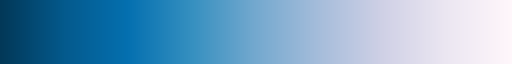

In [86]:
cmap

In [8]:
cmap(0)

(0.00784313725490196, 0.2196078431372549, 0.34509803921568627, 1.0)

As seen in the <a href="./1_2_OSI_SAF_sea_ice_file_structure.ipynb" target="_blank">file structure notebook</a>, Near Real Time products are ditribute in **Polar Stereographic projection**. Let's then explore the file structure to see how it is apllied to northern pole view.

In [9]:
for filename in os.listdir(directory):
    if filename.endswith(".nc"):
        nc = xr.open_dataset(os.path.join(directory, filename))

nc.variables['Polar_Stereographic_Grid']

<xarray.Variable ()> Size: 4B
[1 values with dtype=int32]
Attributes:
    grid_mapping_name:                      polar_stereographic
    false_easting:                          0.0
    false_northing:                         0.0
    area_extent:                            '(-3850000.0, -5350000.0, 3750000...
    semi_major_axis:                        6378273.0
    semi_minor_axis:                        6356889.44891
    straight_vertical_longitude_from_pole:  -45.0
    latitude_of_projection_origin:          90.0
    standard_parallel:                      70.0
    proj4_string:                           +proj=stere +a=6378273 +b=6356889...

In the attribute, you should be able see the 'proj4_string'. It provides us with the information needed to define the cartopy projection setting of our input data :  
* +proj=stere +a=6378273 +b=6356889.44891 +lat_0=90 +lat_ts=70 +lon_0=-45   

Which we will translate into ccrs.Stereographic(central_latitude=90.0, central_longitude=-45.0, true_scale_latitude=70.0).

to note that **these informations are the same for all OSI SAF northern hemisphere near real time products**. We will have a look into the situation for southern hemisphere below.

Let's map the data in its original projection

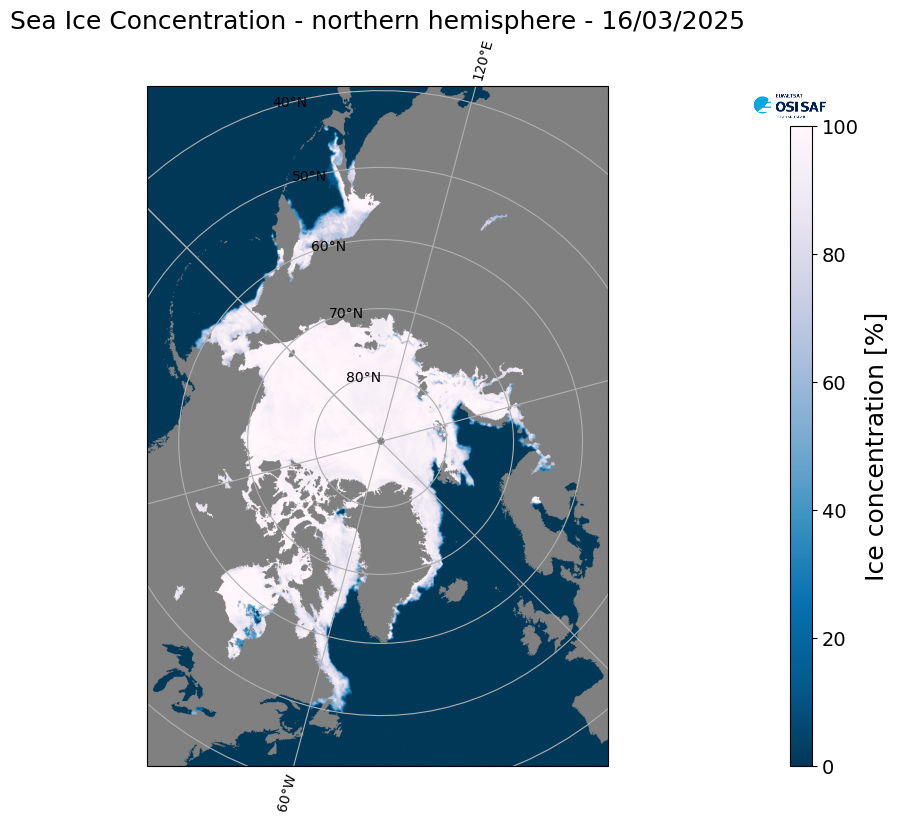

In [10]:
# Create a new figure
fig = plt.figure(figsize=(11,8))

# Map Sea Ice concentration
data_projection=ccrs.Stereographic(central_latitude=90.0, central_longitude=-45.0, true_scale_latitude=70.0)
output_projection=ccrs.Stereographic(central_latitude=90.0, central_longitude=-45.0, true_scale_latitude=70.0)
im = mapping_ice_conc(directory, 
                      data_projection, 
                      output_projection, 
                      cmap=cmap, 
                      title="Sea Ice Concentration - northern hemisphere - "+ filedate)

# Add a colorbar for sea ice concentration
add_colorbar(im, fig, orientation='vertical', cmap=cmap)

Other type of mapping projection can be use to visualize products. All the map projection are available in the  <a href="https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html" target="_blank">cartopy documentation</a> 
Reproject the data in an orthographic view.

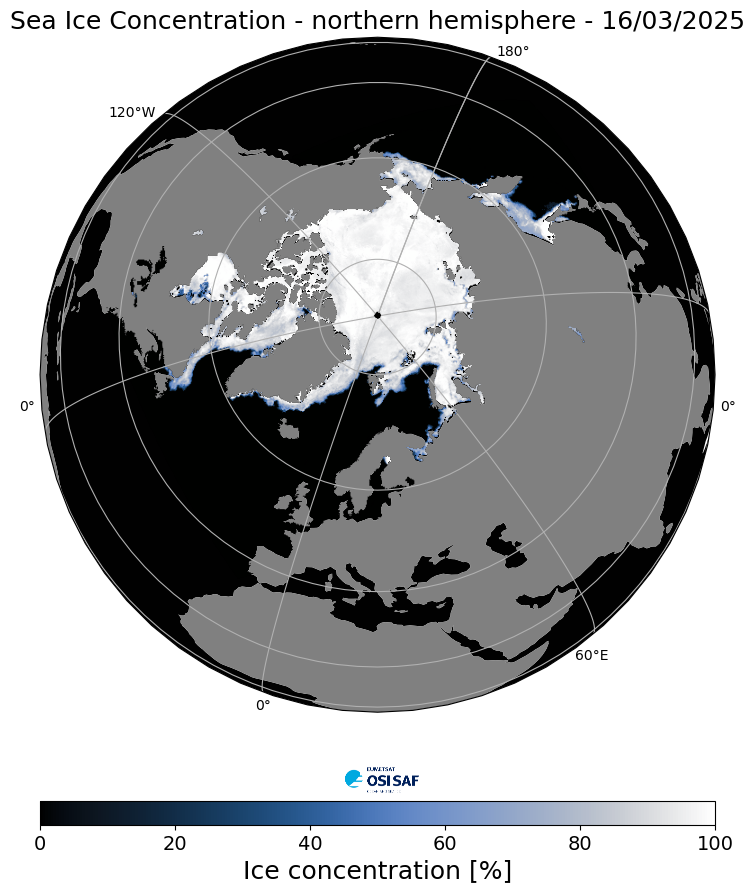

In [84]:
# Create a new figure
fig = plt.figure(figsize=(9,12))

# Map Sea Ice concentration
data_projection=ccrs.Stereographic(central_latitude=90.0, central_longitude=-45.0, true_scale_latitude=70.0)
output_projection=ccrs.Orthographic(20,80)
im = mapping_ice_conc(directory, 
                      data_projection, 
                      output_projection, 
                      cmap=cmap, 
                      title="Sea Ice Concentration - northern hemisphere - "+ filedate)

# Add a colorbar for sea ice concentration
add_colorbar(im, fig, orientation='horizontal', cmap=cmap)

### Southern hemisphere

Setting directory where to read data files

In [89]:
directory = os.path.join(os.getcwd(),'products', 'SI_concentration_AMSR2', 'sh')

Let's check which data we are going to work with, and extract its date from the file name.

In [90]:
for filename in os.listdir(directory):
    filedate=filename[len(filename)-9:-7]+ '/' +filename[len(filename)-11:-9]+ '/' + filename[len(filename)-15:-11]

    print(filename)
    print('retrieval for:', filedate)


ice_conc_sh_polstere-100_amsr2_202506101200.nc
retrieval for: 10/06/2025


As this is a near real time product, it is as well distribute using the **Polar Stereographic** projection. Let's have a look then into how we apply this projection to southern pole.

In [91]:
for filename in os.listdir(directory):
    if filename.endswith(".nc"):
        nc = xr.open_dataset(os.path.join(directory, filename))

nc.variables['Polar_Stereographic_Grid']

<xarray.Variable ()> Size: 4B
[1 values with dtype=int32]
Attributes:
    grid_mapping_name:                      polar_stereographic
    false_easting:                          0.0
    false_northing:                         0.0
    area_extent:                            '(-3950000.0, -3950000.0, 3950000...
    semi_major_axis:                        6378273.0
    semi_minor_axis:                        6356889.44891
    straight_vertical_longitude_from_pole:  0.0
    latitude_of_projection_origin:          -90.0
    standard_parallel:                      -70.0
    proj4_string:                           +proj=stere +a=6378273 +b=6356889...

You should be able see the 'proj4_string', it provides us with the information needed to define the cartopy projection setting of our input data :  
* +proj=stere +a=6378273 +b=6356889.44891 +lat_0=-90 +lat_ts=-70 +lon_0=0   

Which we will translate into ccrs.Stereographic(central_latitude=-90.0, central_longitude=0.0, true_scale_latitude=-70.0).

to note that **this is the projection used for all southern hemisphere near real time products**.

Let's map the data in its original projection

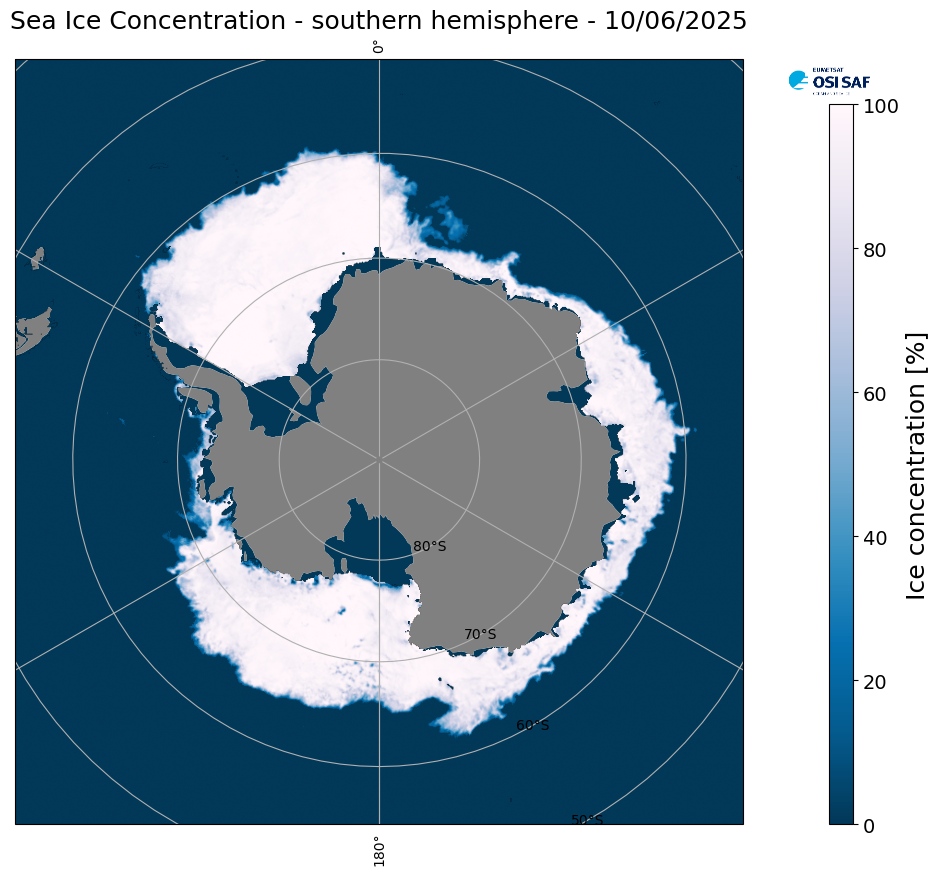

In [92]:
# Create a new figure
fig = plt.figure(figsize=(12,9))

# Map Sea Ice concentration
data_projection=ccrs.Stereographic(central_latitude=-90.0, central_longitude=0, true_scale_latitude=-70.0)
output_projection=ccrs.Stereographic(central_latitude=-90.0, central_longitude=0, true_scale_latitude=-70.0)
im = mapping_ice_conc(directory, 
                      data_projection, 
                      output_projection, 
                      cmap=cmap, 
                      title="Sea Ice Concentration - southern hemisphere - "+ filedate)

# Add a colorbar for sea ice concentration
add_colorbar(im, fig, orientation='vertical', cmap=cmap)

You should notice on the figure above, that there are missing areas of data around the Antarctic continent. These correspond to Ice Shelves that are not included directly in cartopy LAND boundaries. So let's add them to the plot.

In [96]:
ice_shelves = cfeature.NaturalEarthFeature(
        category='physical',
        name='antarctic_ice_shelves_polys',
        scale='10m',
        facecolor='grey',
        edgecolor='grey')

Plot with Ice Shelves.

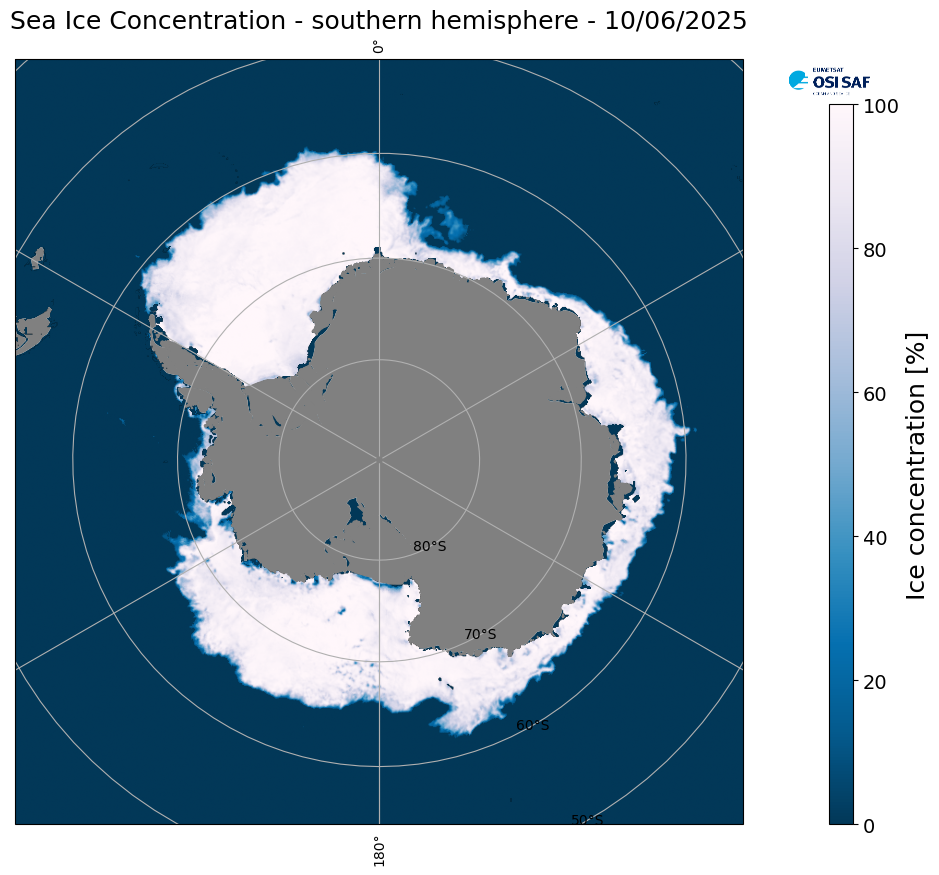

In [97]:
# Create a new figure
fig = plt.figure(figsize=(12,9))

# Map Sea Ice concentration
data_projection=ccrs.Stereographic(central_latitude=-90.0, central_longitude=0, true_scale_latitude=-70.0)
output_projection=ccrs.Stereographic(central_latitude=-90.0, central_longitude=0, true_scale_latitude=-70.0)
im = mapping_ice_conc(directory, 
                      data_projection, 
                      output_projection, 
                      cmap=cmap, 
                      ice_shelves=ice_shelves, 
                      title="Sea Ice Concentration - southern hemisphere - "+ filedate)

# Add a colorbar for sea ice concentration
add_colorbar(im, fig, orientation='vertical', cmap=cmap)

Other type of mapping projection can be use to visualize products. All the map projection are available in the  <a href="https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html" target="_blank">cartopy documentation</a> 
Reproject the data in an orthographic view.
Reproject the data in an orthographic view.

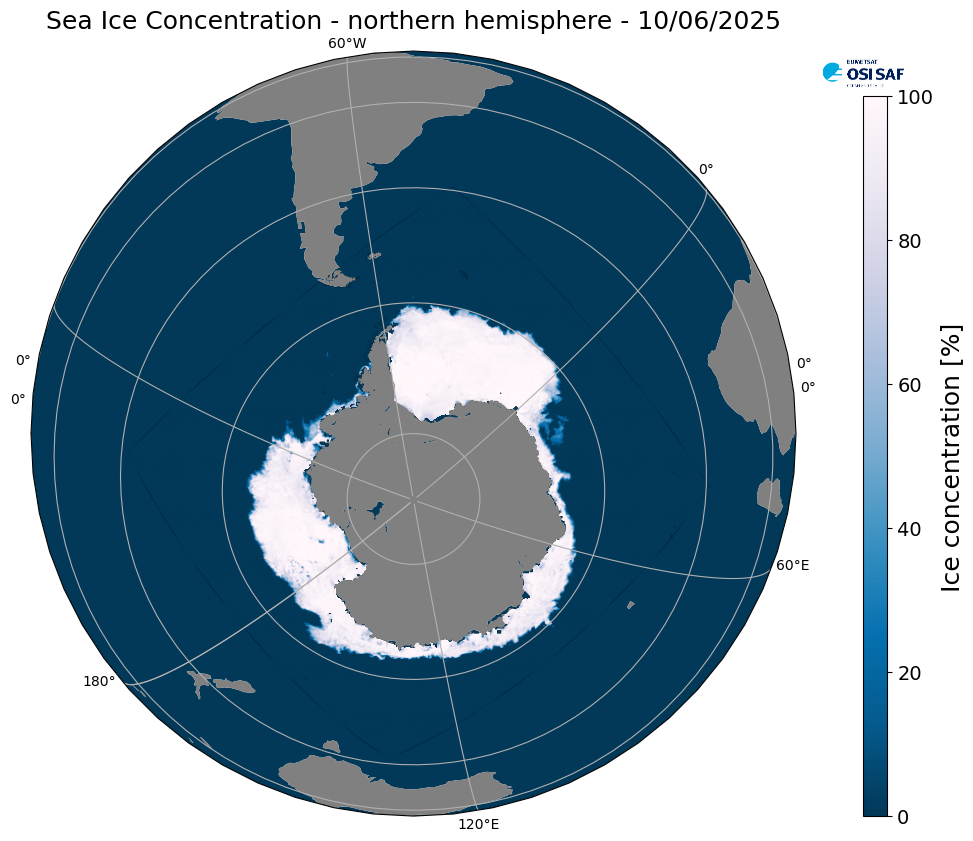

In [98]:
# Create a new figure
fig = plt.figure(figsize=(12,9))

# Map Sea Ice concentration
data_projection=ccrs.Stereographic(central_latitude=-90.0, central_longitude=0, true_scale_latitude=-70.0)
output_projection=ccrs.Orthographic(-50,-80)
im = mapping_ice_conc(directory, 
                      data_projection, 
                      output_projection, 
                      cmap=cmap,
                      ice_shelves=ice_shelves, 
                      title="Sea Ice Concentration - northern hemisphere - "+ filedate)

# Add a colorbar for sea ice concentration
add_colorbar(im, fig, orientation='vertical', cmap=cmap)

##
<div class="alert alert-info" role="alert">

## <a id='section2'></a>2. Mapping near real time data - Level 2 PMW sea ice concentration

[Back to top](#TOC-TOP)

</div>

Each Level 2 file correspond to a full orbit of data asquisition. Each AMSR L2 file consequently includes sea ice concentration measurements for both pole. Let's map the data in its original projection for north and south hemisphere.

### AMSR Sea Ice Concentration data

Setting directory where to read data files

In [20]:
directory = os.path.join(os.getcwd(), 'products', 'SI_concentration_L2','AMSR')

Let's check which data we are going to work with, and extract its date from the file name.

In [21]:
for filename in os.listdir(directory):
    filedate=filename[len(filename)-9:-7]+ '/' +filename[len(filename)-11:-9]+ '/' + filename[len(filename)-15:-11]

    print(filename)
    print('retrieval for:', filedate)


ice_conc_l2_amsr2_gw1_202507011445.nc
retrieval for: 01/07/2025


Set geographical area for north hemisphere

In [23]:
lon_min_nh = -180
lon_max_nh = 180
lat_min_nh = 40
lat_max_nh = 90

Set geographical area for south hemisphere

In [24]:
lon_min_sh = -180
lon_max_sh = 180
lat_min_sh = -40
lat_max_sh = -90

Let's map the data in its original projection for each hemisphere

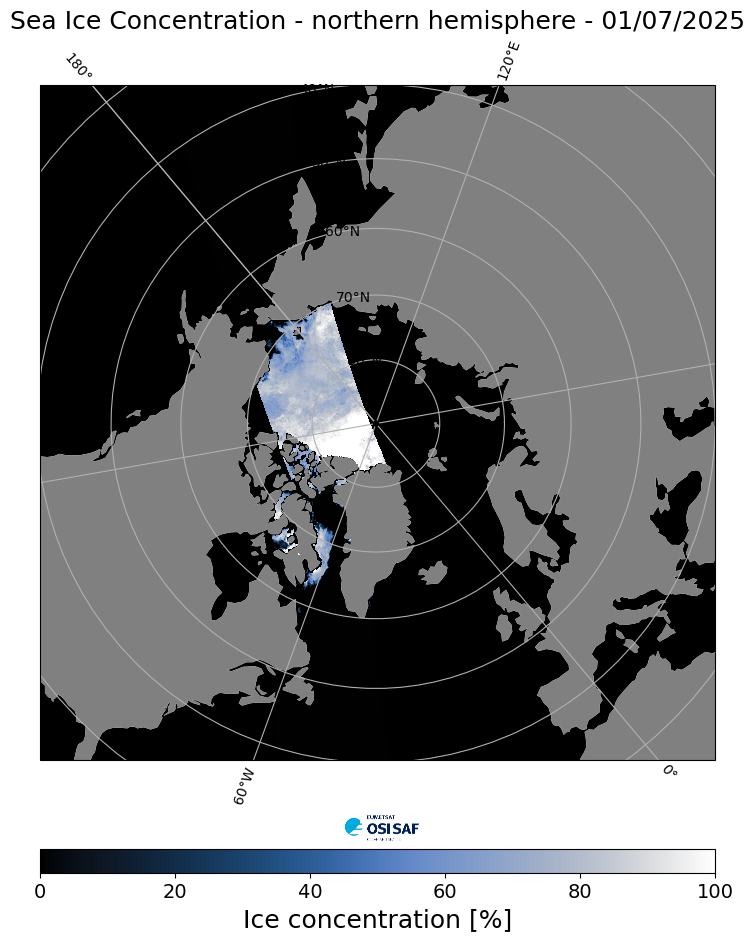

In [25]:
# Create a new figure
fig = plt.figure(figsize=(9,12))

# Map Sea Ice concentration
data_projection=ccrs.PlateCarree()
output_projection=ccrs.NorthPolarStereo(-40)
im = mapping_ice_conc(directory, 
                      data_projection, 
                      output_projection, 
                      cmap=cmap, 
                      region=[lon_min_nh,lon_max_nh,lat_min_nh,lat_max_nh],
                      title="Sea Ice Concentration - northern hemisphere - "+ filedate)


# Add a colorbar for sea ice concentration
add_colorbar(im, fig, orientation='horizontal', cmap=cmap)

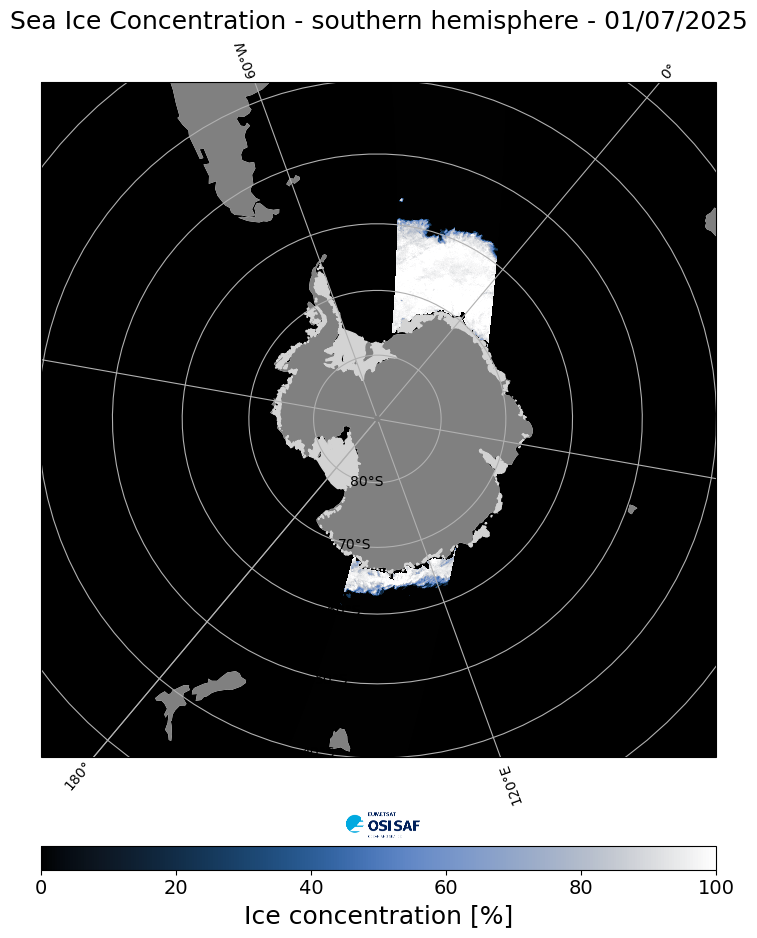

In [26]:
# Create a new figure
fig = plt.figure(figsize=(9,12))

# Map Sea Ice concentration
data_projection=ccrs.PlateCarree()
output_projection=ccrs.SouthPolarStereo(-40)
im = mapping_ice_conc(directory, 
                      data_projection, 
                      output_projection, 
                      cmap=cmap, 
                      ice_shelves=ice_shelves,
                      region=[lon_min_sh,lon_max_sh,lat_min_sh,lat_max_sh],
                      title="Sea Ice Concentration - southern hemisphere - "+ filedate)


# Add a colorbar for sea ice concentration
add_colorbar(im, fig, orientation='horizontal', cmap=cmap)

##
<div class="alert alert-info" role="alert">

## <a id='section3'></a>3. Mapping climate data - Global Sea Ice Concentration climate data record (SMMR/SSMI/SSMIS), release 3

[Back to top](#TOC-TOP)

</div>

This is a Climate Data Record: satellite observation have been reprocess for higher quality. It provides daily Sea Ice Concentration assessments on both poles between the covers a period ranging from the 20th October 1978 to the 31st december 2020. As such it is the longest Satellite Sea Ice Concentration time series, dating back from the early age of satellite based earth observation. It is complemented by a Interim Climate Data Record (ICDR), ranging from 1st January 2021 to 16th October 2025, that is composed of daily assessment, calculated with a latency of 16 days. The ICDR was interrupted in october 2025, following the scattered production of the SSMIS sensors onboard satellites the US Defense Meteorological Satellite Programm. As these satellites long production period is coming to an end, we decided to suspend the product. The time serie might be resume when the passive microwave sensor NWI aboard the Metop-SG-B, which have similar caracteristics with SSMIS, will be commissioned.

### Northern hemisphere

Setting directory where to read data files

In [27]:
directory = os.path.join(os.getcwd(), 'products', 'SI_concentration_SSM_CDR3_1', 'nh')

Let's check which data we are going to work with, and extract its date from the file name.

In [28]:
for filename in os.listdir(directory):
    filedate=filename[len(filename)-9:-7]+ '/' +filename[len(filename)-11:-9]+ '/' + filename[len(filename)-15:-11]

    print(filename)
    print('retrieval for:', filedate)


ice_conc_nh_ease2-250_cdr-v3p1_201306121200.nc
retrieval for: 12/06/2013


We are now working on a climate product. As seen in the <a href="./1_2_OSI_SAF_sea_ice_file_structure.ipynb" target="_blank">file stucture notebook</a>, the projection will then be **Lambert Azimuthal Equal-Area**. Let's have a deeper look into how are formated the Northern Hemisphere products.

In [30]:
for filename in os.listdir(directory):
    if filename.endswith(".nc"):
        nc = xr.open_dataset(os.path.join(directory, filename))

nc.variables['Lambert_Azimuthal_Grid']

<xarray.Variable ()> Size: 4B
[1 values with dtype=int32]
Attributes:
    grid_mapping_name:               lambert_azimuthal_equal_area
    longitude_of_projection_origin:  0.0
    latitude_of_projection_origin:   90.0
    false_easting:                   0.0
    false_northing:                  0.0
    semi_major_axis:                 6378137.0
    inverse_flattening:              298.257223563
    proj4_string:                    +proj=laea +lon_0=0 +datum=WGS84 +ellps=...

You should be able see the 'proj4_string', it provides us with the information needed to define the cartopy projection setting of our input data :  
* +proj=laea +lon_0=0 +datum=WGS84 +ellps=WGS84 +lat_0=90.0   

Which we will translate into ccrs.LambertAzimuthalEqualArea(central_longitude=0.0, central_latitude=90.0).

This will be the same for **all northern hemisphere climate products**.

Let's map the data in its original projection

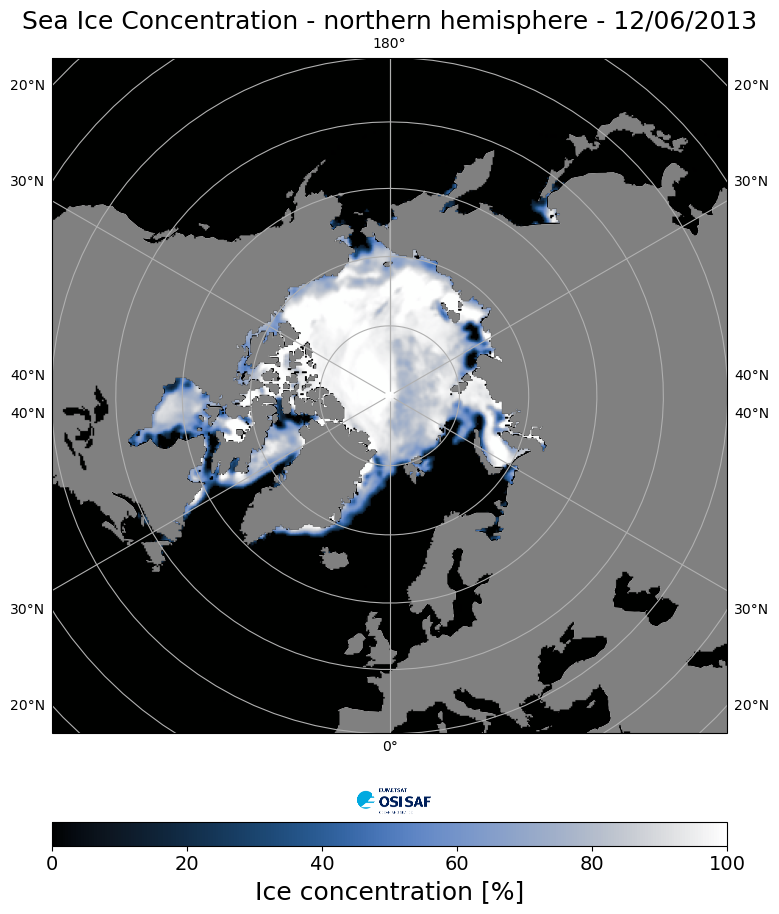

In [31]:
# Create a new figure
fig = plt.figure(figsize=(9,12))

# Map Sea Ice concentration
data_projection=ccrs.LambertAzimuthalEqualArea(central_longitude=0.0, central_latitude=90.0)
output_projection=ccrs.LambertAzimuthalEqualArea(central_longitude=0.0, central_latitude=90.0)
im = mapping_ice_conc(directory, 
                      data_projection, 
                      output_projection, 
                      cmap=cmap, 
                      ice_shelves=ice_shelves,
                      title="Sea Ice Concentration - northern hemisphere - "+ filedate)

# Adding colorbar
add_colorbar(im, fig, orientation='horizontal', cmap=cmap)

Other type of mapping projection can be use to visualize products. All the map projection are available in the  <a href="https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html" target="_blank">cartopy documenation</a> 
Reproject the data in an orthographic view.

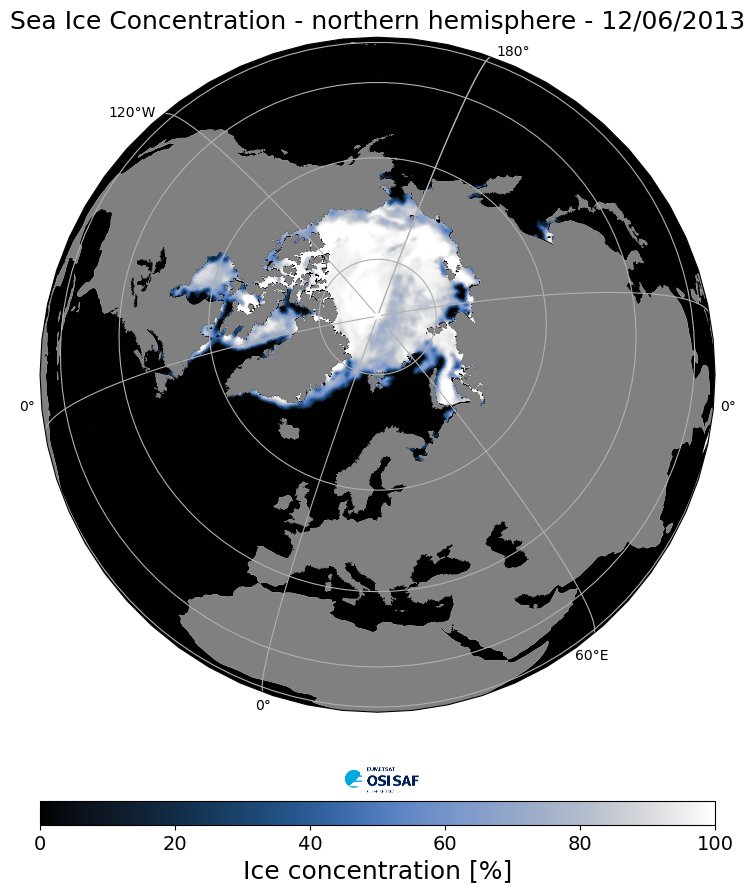

In [32]:
# Create a new figure
fig = plt.figure(figsize=(9,12))

# Map Sea Ice concentration
data_projection=ccrs.LambertAzimuthalEqualArea(central_longitude=0.0, central_latitude=90.0)
output_projection=ccrs.Orthographic(20,80)
im = mapping_ice_conc(directory, 
                      data_projection, 
                      output_projection, 
                      cmap=cmap, 
                      ice_shelves=ice_shelves,
                      title="Sea Ice Concentration - northern hemisphere - "+ filedate)

# Adding a colorbar
add_colorbar(im, fig, orientation='horizontal', cmap=cmap)

### Southern hemisphere

Setting directory where to read data files

In [33]:
directory = os.path.join(os.getcwd(), 'products', 'SI_concentration_SSM_CDR3_1', 'sh')

Let's check which data we are going to work with, and extract its date from the file name.

In [34]:
for filename in os.listdir(directory):
    filedate=filename[len(filename)-9:-7]+ '/' +filename[len(filename)-11:-9]+ '/' + filename[len(filename)-15:-11]

    print(filename)
    print('retrieval for:', filedate)


ice_conc_sh_ease2-250_cdr-v3p1_201306121200.nc
retrieval for: 12/06/2013


Let's now look how the Lambert Azimuthal equal-Area projection is applied to the Southern Hemisphere products:

In [36]:
for filename in os.listdir(directory):
    if filename.endswith(".nc"):
        nc = xr.open_dataset(os.path.join(directory, filename))
        print(filename)

nc.variables['Lambert_Azimuthal_Grid']

ice_conc_sh_ease2-250_cdr-v3p1_201306121200.nc


<xarray.Variable ()> Size: 4B
[1 values with dtype=int32]
Attributes:
    grid_mapping_name:               lambert_azimuthal_equal_area
    longitude_of_projection_origin:  0.0
    latitude_of_projection_origin:   -90.0
    false_easting:                   0.0
    false_northing:                  0.0
    semi_major_axis:                 6378137.0
    inverse_flattening:              298.257223563
    proj4_string:                    +proj=laea +lon_0=0 +datum=WGS84 +ellps=...

You should be able see the 'proj4_string', it provides us with the information needed to define the cartopy projection setting of our input data :  
* +proj=laea +lon_0=0 +datum=WGS84 +ellps=WGS84 +lat_0=90.0   

Which we will translate into ccrs.LambertAzimuthalEqualArea(central_longitude=0.0, central_latitude=-90.0).

This will be the same for all **Southern Hemisphere Climate Products**.

Let's map the data in its original projection

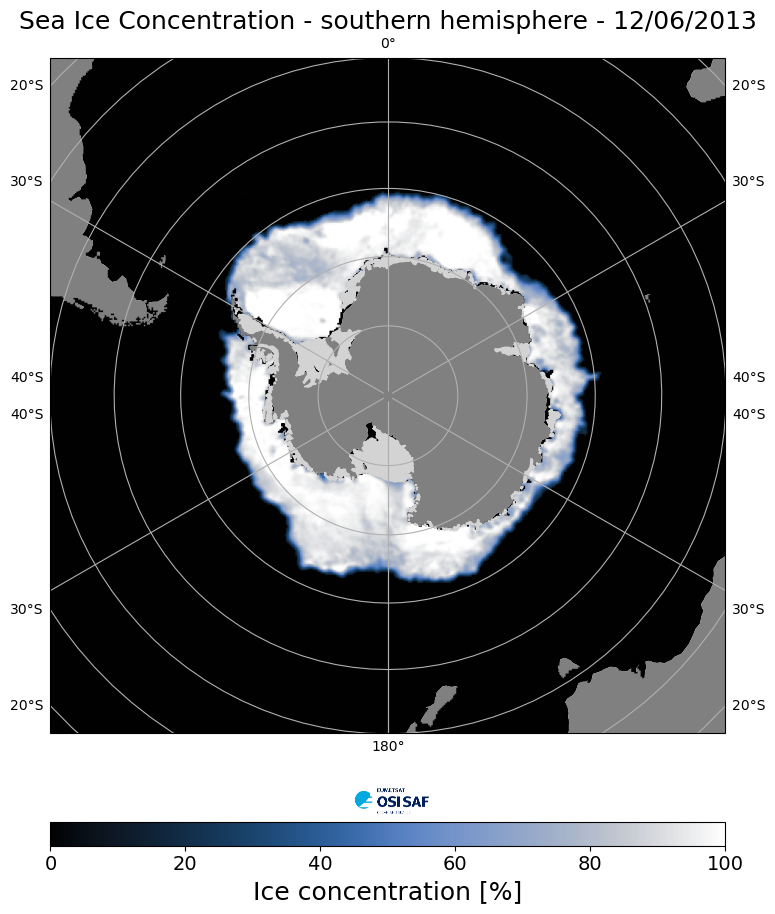

In [37]:
# Create a new figure
fig = plt.figure(figsize=(9,12))

# Map Sea Ice concentration
data_projection=ccrs.LambertAzimuthalEqualArea(central_longitude=0.0, central_latitude=-90.0)
output_projection=ccrs.LambertAzimuthalEqualArea(central_longitude=0.0, central_latitude=-90.0)
im = mapping_ice_conc(directory, 
                      data_projection, 
                      output_projection, 
                      cmap=cmap, 
                      ice_shelves=ice_shelves,
                      title="Sea Ice Concentration - southern hemisphere - "+ filedate)

add_colorbar(im, fig, orientation='horizontal', cmap=cmap)

Other type of mapping projection can be use to visualize products. All the map projection are available in the  <a href="https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html" target="_blank">cartopy documenation</a> 
Reproject the data in an orthographic view.
Reproject the data in an orthographic view.

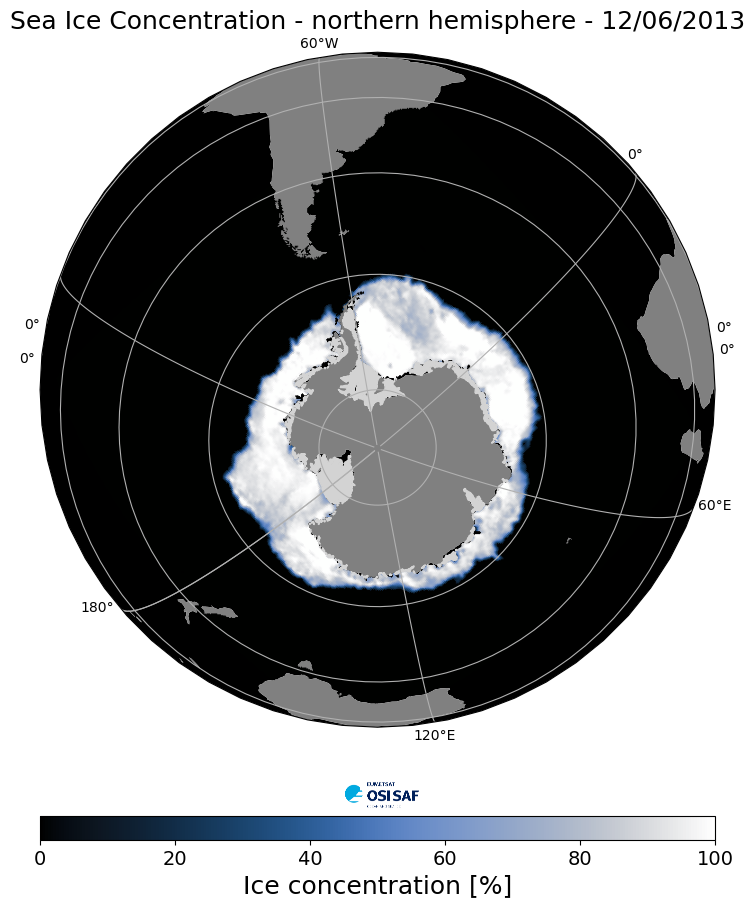

In [38]:
# Create a new figure
fig = plt.figure(figsize=(9,12))

# Map Sea Ice concentration
data_projection=ccrs.LambertAzimuthalEqualArea(central_longitude=0.0, central_latitude=-90.0)
output_projection=ccrs.Orthographic(-50,-80)
im = mapping_ice_conc(directory, 
                      data_projection, 
                      output_projection, 
                      cmap=cmap, 
                      ice_shelves=ice_shelves,
                      title="Sea Ice Concentration - northern hemisphere - "+ filedate)

add_colorbar(im, fig, orientation='horizontal', cmap=cmap)

##
<div class="alert alert-info" role="alert">

## <a id='section4'></a>4. Mapping climate data - Global Sea Ice Concentration climate data record (AMSR), release 3

[Back to top](#TOC-TOP)

</div>

This Climate Data Record is based on the Japanese JAXA's sensors (AMSR-E that operated aboard the NASA satellite Aqua, and AMSR2, currently operating on the JAXA's satellite GCOM-W). The CDR provide assessments of Sea Ice Concentration at both pole from the 1st of June 2002 to the 31st december 2020. It is complemented by the ICDR described below.

### Northern hemisphere

Setting directory where to read data files

In [39]:
directory = os.path.join(os.getcwd(), 'products', 'SI_concentration_AMSR_CDR3', 'nh')

Let's check which data we are going to work with, and extract its date from the file name.

In [40]:
for filename in os.listdir(directory):
    filedate=filename[len(filename)-9:-7]+ '/' +filename[len(filename)-11:-9]+ '/' + filename[len(filename)-15:-11]

    print(filename)
    print('retrieval for:', filedate)


ice_conc_nh_ease2-250_cdr-v3p0-amsr_201306121200.nc
retrieval for: 12/06/2013


Let's map the data in its original projection

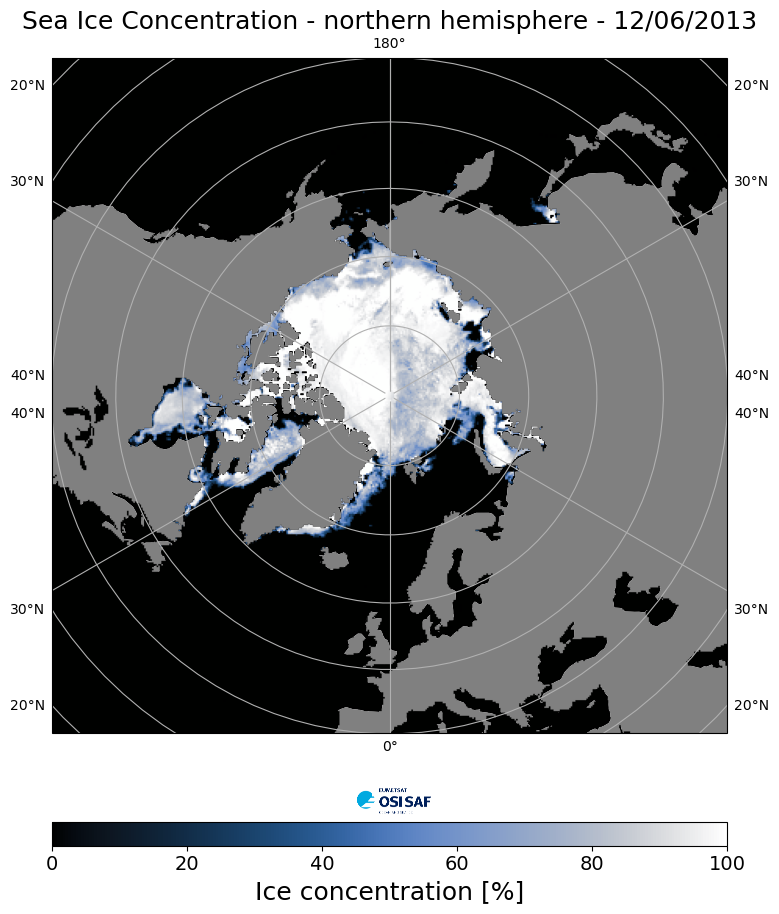

In [42]:
# Create a new figure
fig = plt.figure(figsize=(9,12))

# Map Sea Ice concentration
data_projection=ccrs.LambertAzimuthalEqualArea(central_longitude=0.0, central_latitude=90.0)
output_projection=ccrs.LambertAzimuthalEqualArea(central_longitude=0.0, central_latitude=90.0)
im = mapping_ice_conc(directory, 
                      data_projection, 
                      output_projection, 
                      cmap=cmap, 
                      ice_shelves=ice_shelves,
                      title="Sea Ice Concentration - northern hemisphere - "+ filedate)

add_colorbar(im, fig, orientation='horizontal', cmap=cmap)

Other type of mapping projection can be use to visualize products. All the map projection are available in the  <a href="https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html" target="_blank">cartopy documenation</a> 
Reproject the data in an orthographic view.

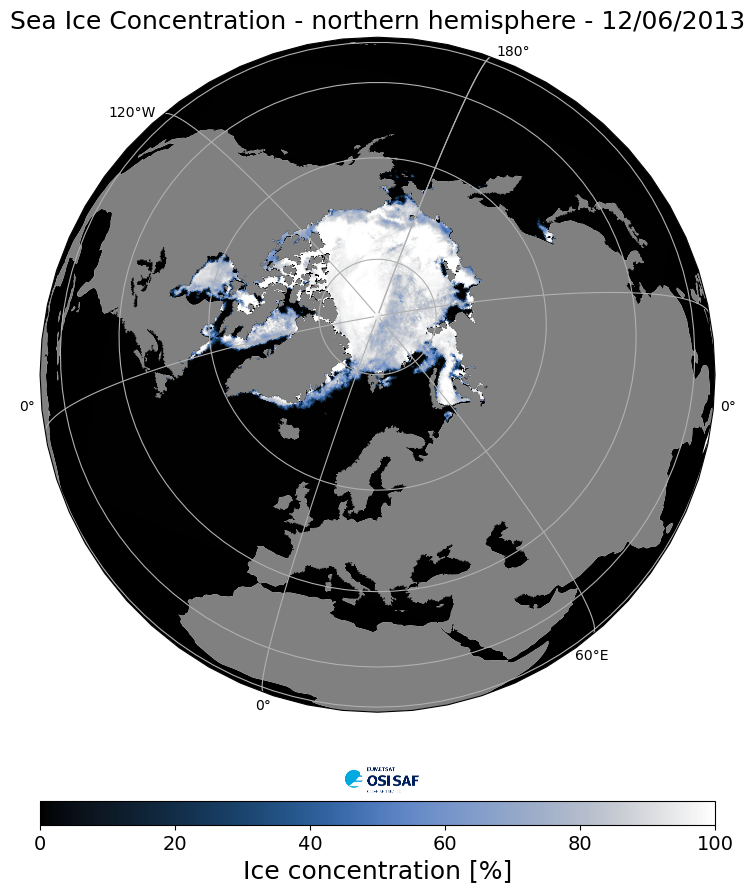

In [43]:
# Create a new figure
fig = plt.figure(figsize=(9,12))

# Map Sea Ice concentration
data_projection=ccrs.LambertAzimuthalEqualArea(central_longitude=0.0, central_latitude=90.0)
output_projection=ccrs.Orthographic(20,80)
im = mapping_ice_conc(directory, 
                      data_projection, 
                      output_projection, 
                      cmap=cmap, 
                      ice_shelves=ice_shelves,
                      title="Sea Ice Concentration - northern hemisphere - "+ filedate)

add_colorbar(im, fig, orientation='horizontal', cmap=cmap)

### Southern hemisphere

Setting directory where to read data files

In [44]:
directory = os.path.join(os.getcwd(), 'products', 'SI_concentration_AMSR_CDR3', 'sh')

Let's check which data we are going to work with, and extract its date from the file name.

In [45]:
for filename in os.listdir(directory):
    filedate=filename[len(filename)-9:-7]+ '/' +filename[len(filename)-11:-9]+ '/' + filename[len(filename)-15:-11]

    print(filename)
    print('retrieval for:', filedate)


ice_conc_sh_ease2-250_cdr-v3p0-amsr_201306121200.nc
retrieval for: 12/06/2013


Let's map the data in its original projection

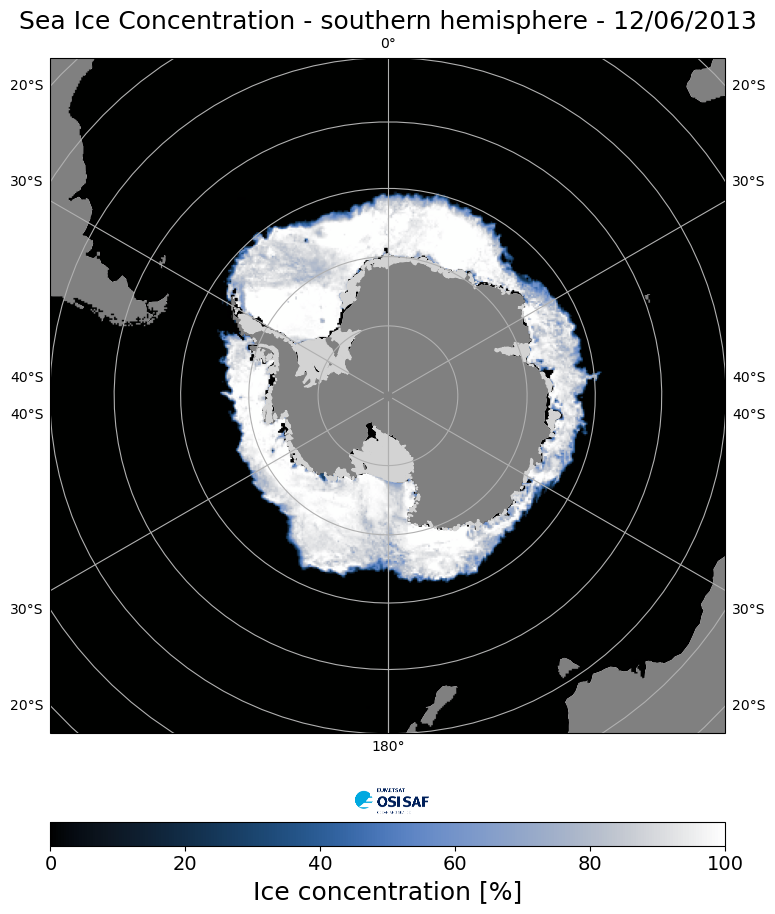

In [47]:
# Create a new figure
fig = plt.figure(figsize=(9,12))

# Map Sea Ice concentration
data_projection=ccrs.LambertAzimuthalEqualArea(central_longitude=0.0, central_latitude=-90.0)
output_projection=ccrs.LambertAzimuthalEqualArea(central_longitude=0.0, central_latitude=-90.0)
im = mapping_ice_conc(directory, 
                      data_projection, 
                      output_projection, 
                      cmap=cmap, 
                      ice_shelves=ice_shelves,
                      title="Sea Ice Concentration - southern hemisphere - "+ filedate)

add_colorbar(im, fig, orientation='horizontal', cmap=cmap)

Other type of mapping projection can be use to visualize products. All the map projection are available in the  <a href="https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html" target="_blank">cartopy documenation</a> 
Reproject the data in an orthographic view.
Reproject the data in an orthographic view.

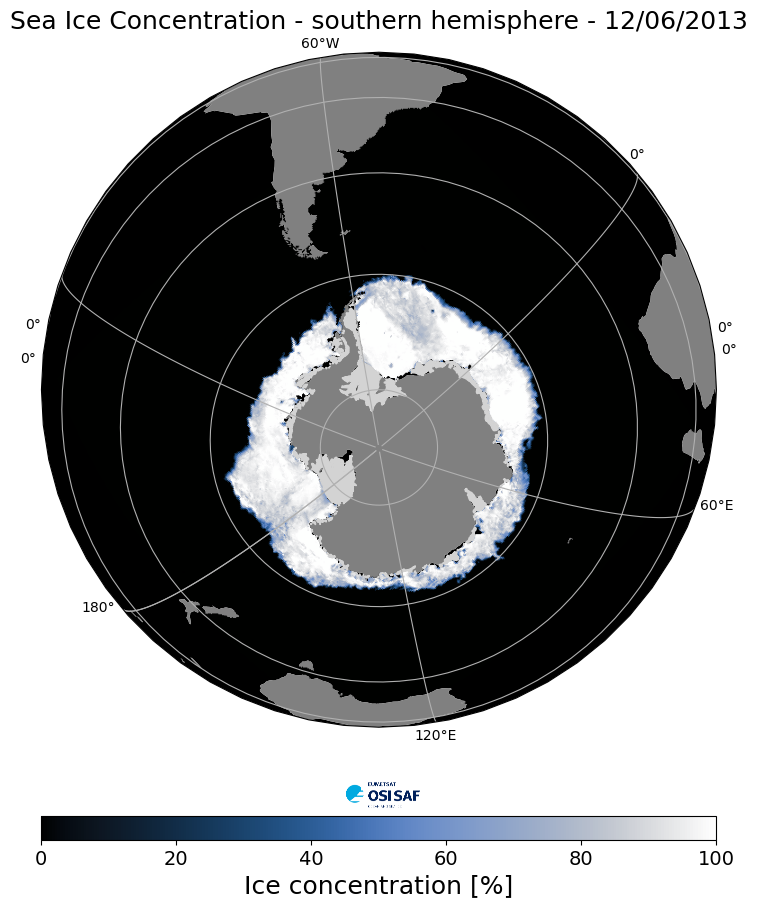

In [48]:
# Create a new figure
fig = plt.figure(figsize=(9,12))

# Map Sea Ice concentration
data_projection=ccrs.LambertAzimuthalEqualArea(central_longitude=0.0, central_latitude=-90.0)
output_projection=ccrs.Orthographic(-50,-80)
im = mapping_ice_conc(directory, 
                      data_projection, 
                      output_projection, 
                      cmap=cmap, 
                      ice_shelves=ice_shelves,
                      title="Sea Ice Concentration - southern hemisphere - "+ filedate)

add_colorbar(im, fig, orientation='horizontal', cmap=cmap)

##
<div class="alert alert-info" role="alert">

## <a id='section5'></a>5. Mapping climate data - Global Sea Ice Concentration interim climate data record (AMSR), release 3

[Back to top](#TOC-TOP)

</div>

### Northern hemisphere

Setting directory where to read data files

In [49]:
directory = os.path.join(os.getcwd(), 'products', 'SI_concentration_AMSR_ICDR3', 'nh')

Let's check which data we are going to work with, and extract its date from the file name.

In [50]:
for filename in os.listdir(directory):
    filedate=filename[len(filename)-9:-7]+ '/' +filename[len(filename)-11:-9]+ '/' + filename[len(filename)-15:-11]

    print(filename)
    print('retrieval for:', filedate)


ice_conc_nh_ease2-250_icdr-v3p0-amsr_202601251200.nc
retrieval for: 25/01/2026


Let's map the data in its original projection

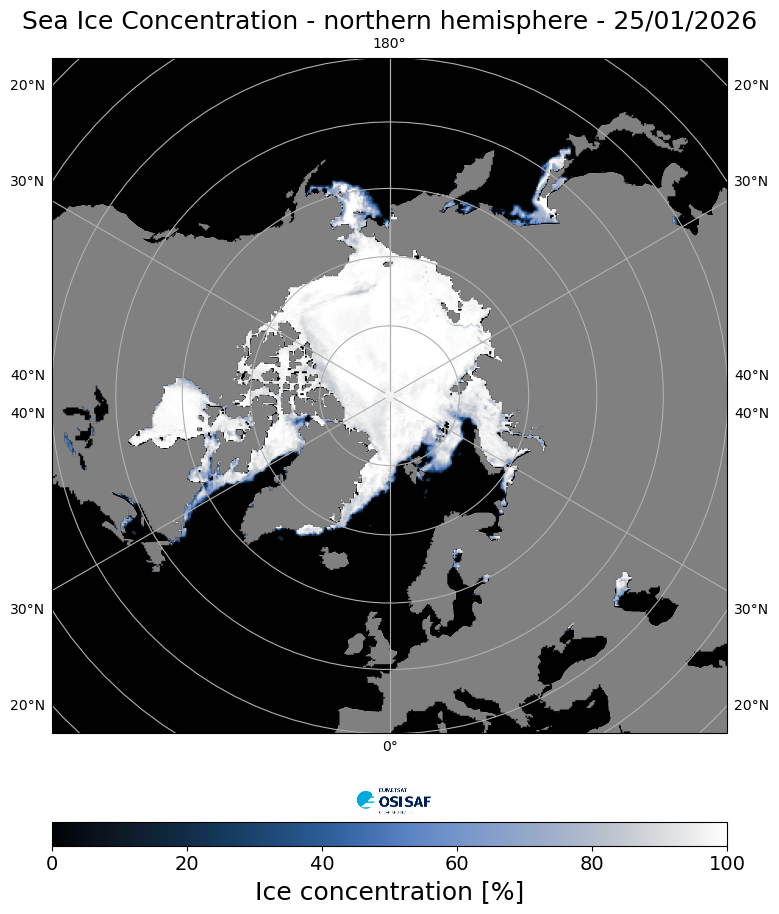

In [52]:
# Create a new figure
fig = plt.figure(figsize=(9,12))

# Map Sea Ice concentration
data_projection=ccrs.LambertAzimuthalEqualArea(central_longitude=0.0, central_latitude=90.0)
output_projection=ccrs.LambertAzimuthalEqualArea(central_longitude=0.0, central_latitude=90.0)
im = mapping_ice_conc(directory, 
                      data_projection, 
                      output_projection, 
                      cmap=cmap, 
                      title="Sea Ice Concentration - northern hemisphere - "+ filedate)

add_colorbar(im, fig, orientation='horizontal', cmap=cmap)

Other type of mapping projection can be use to visualize products. All the map projection are available in the  <a href="https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html" target="_blank">cartopy documenation</a> 
Reproject the data in an orthographic view.

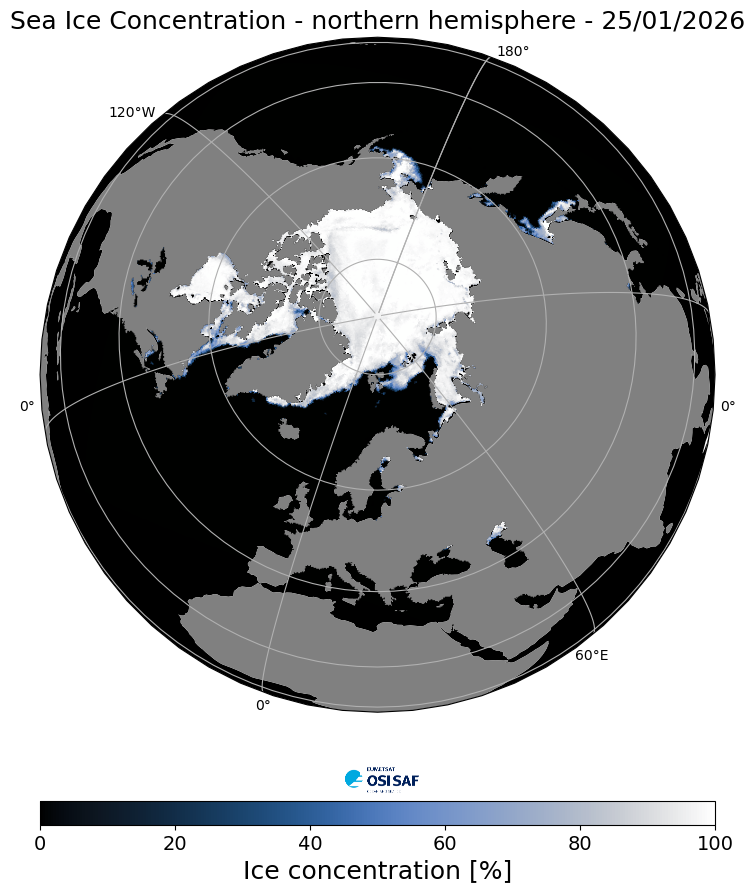

In [53]:
# Create a new figure
fig = plt.figure(figsize=(9,12))

# Map Sea Ice concentration
data_projection=ccrs.LambertAzimuthalEqualArea(central_longitude=0.0, central_latitude=90.0)
output_projection=ccrs.Orthographic(20,80)
im = mapping_ice_conc(directory, 
                      data_projection, 
                      output_projection, 
                      cmap=cmap, 
                      title="Sea Ice Concentration - northern hemisphere - "+ filedate)

add_colorbar(im, fig, orientation='horizontal', cmap=cmap)

### Southern hemisphere

Setting directory where to read data files

In [54]:
directory = os.path.join(os.getcwd(), 'products', 'SI_concentration_AMSR_ICDR3', 'sh')

Let's check which data we are going to work with, and extract its date from the file name.

In [55]:
for filename in os.listdir(directory):
    filedate=filename[len(filename)-9:-7]+ '/' +filename[len(filename)-11:-9]+ '/' + filename[len(filename)-15:-11]

    print(filename)
    print('retrieval for:', filedate)


ice_conc_sh_ease2-250_icdr-v3p0-amsr_202601251200.nc
retrieval for: 25/01/2026


Let's map the data in its original projection

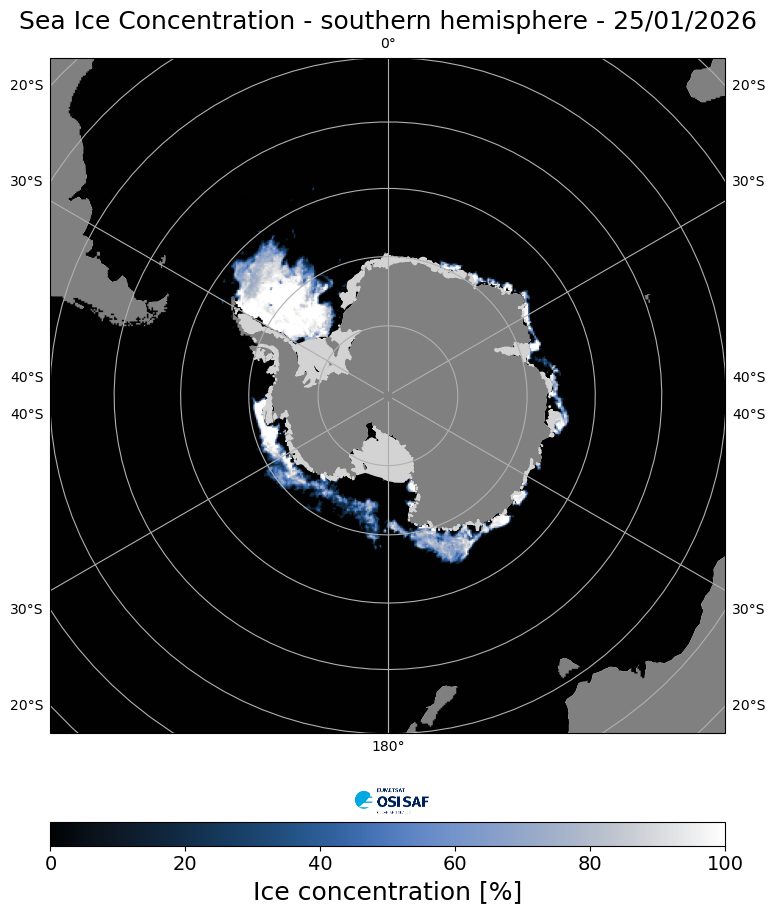

In [57]:
# Create a new figure
fig = plt.figure(figsize=(9,12))

# Map Sea Ice concentration
data_projection=ccrs.LambertAzimuthalEqualArea(central_longitude=0.0, central_latitude=-90.0)
output_projection=ccrs.LambertAzimuthalEqualArea(central_longitude=0.0, central_latitude=-90.0)
im = mapping_ice_conc(directory, 
                      data_projection, 
                      output_projection, 
                      cmap=cmap, 
                      ice_shelves=ice_shelves,
                      title="Sea Ice Concentration - southern hemisphere - "+ filedate)

add_colorbar(im, fig, orientation='horizontal', cmap=cmap)

Other type of mapping projection can be use to visualize products. All the map projection are available in the  <a href="https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html" target="_blank">cartopy documenation</a> 
Reproject the data in an orthographic view.
Reproject the data in an orthographic view.

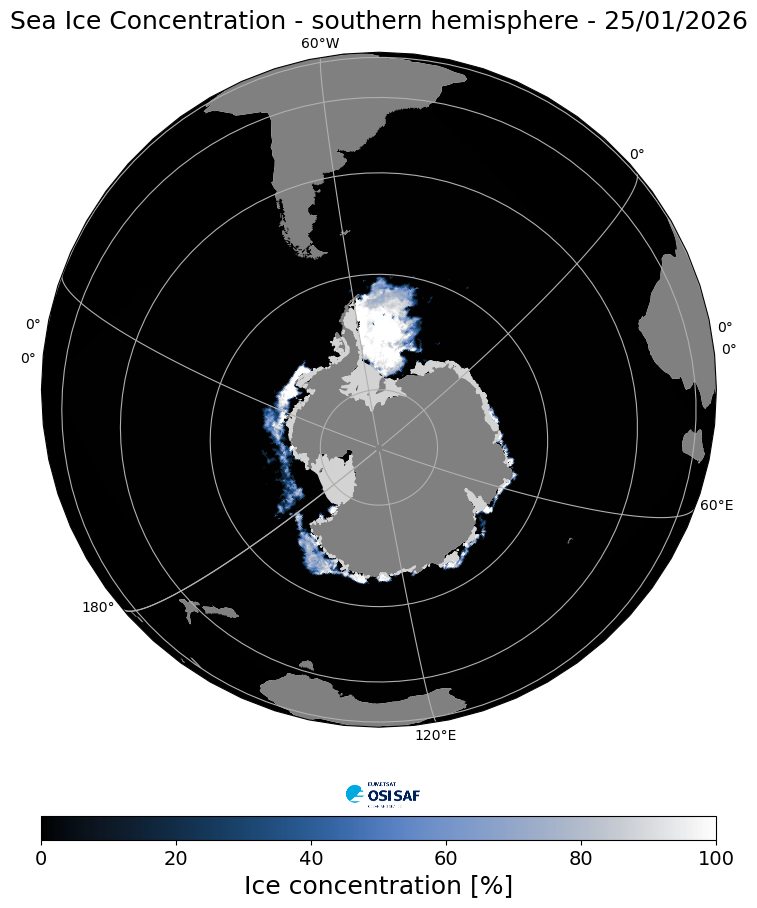

In [58]:
# Create a new figure
fig = plt.figure(figsize=(9,12))

# Map Sea Ice concentration
data_projection=ccrs.LambertAzimuthalEqualArea(central_longitude=0.0, central_latitude=-90.0)
output_projection=ccrs.Orthographic(-50,-80)
im = mapping_ice_conc(directory, 
                      data_projection, 
                      output_projection, 
                      cmap=cmap,
                      ice_shelves=ice_shelves, 
                      title="Sea Ice Concentration - southern hemisphere - "+ filedate)

# Adding a colorbar
add_colorbar(im, fig, orientation='horizontal', cmap=cmap)


<hr>
<a href="../Index.ipynb" target="_blank"><< Index</a>
<br>
<a href="./1_2_OSI_SAF_sea_ice_file_structure.ipynb" target="_blank"><< Exploring OSI SAF sea ice file structure</a>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="./1_3b_OSI_SAF_sea_ice_mapping_ice_edge.ipynb" target="_blank">Mapping OSI SAF sea ice edge >></a>
<hr>
<a href="https://gitlab.eumetsat.int/eumetlab/ocean">View on GitLab</a> | <a href="https://training.eumetsat.int/">EUMETSAT Training</a> | <a href=mailto:ops@eumetsat.int>Contact helpdesk for support </a> | <a href=mailto:training@eumetsat.int>Contact our training team to collaborate on and reuse this material</a></span></p>